In [4]:
!pip install git+https://github.com/Blealtan/efficient-kan.git

  Cloning https://github.com/Blealtan/efficient-kan.git to /tmp/pip-req-build-psw8x3vc
  Running command git clone --filter=blob:none --quiet https://github.com/Blealtan/efficient-kan.git /tmp/pip-req-build-psw8x3vc
  Resolved https://github.com/Blealtan/efficient-kan.git to commit 7b6ce1c87f18c8bc90c208f6b494042344216b11
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
!pip install catboost

# 4 models at once: Catboost, KAN, HistGradientBoosting and LGBM

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import  HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from efficient_kan import KAN
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess data
df = pd.read_csv(r"data/Megy_final.csv")
df = df.drop(columns=['x', 'y', 'z', 'link', 'orig_c1', 'orig_c2'])

In [ ]:
rename_dict = {
    'space_group_core': 'Space group (Core)',
    'space_group_shell': 'Space group (Shell)',
    'Tc': 'Temperature Curie (Tc)',
    'shape': 'Particle shape',
    'temperature_k': 'Temperature (K)',
    'h_range_max_koe': 'Max field range (kOe)',
    'sat_em_g': 'Saturation magnetization (emu/g)',
    'coer_oe': 'Coercivity (Oe)',
    'mr (emu/g)': 'Remanence magnetization (emu/g)',
    'sphericity': 'Sphericity',
    'max/min': 'Max/Min ratio',
    'area/volume': 'Area/Volume ratio',
    'num_of_magn_ions': 'Magnetic ions count',
    'core_b': 'Core B',
    'core_alpha': 'Core alpha',
    'core_beta': 'Core beta',
    'core_gamma': 'Core gamma',
    'shell_b': 'Shell B',
    'shell_alpha': 'Shell alpha',
    'shell_beta': 'Shell beta',
    'shell_gamma': 'Shell gamma',
    'Aex': 'Exchange stiffness constant (Aex)',
    'core_c/a': 'Core c/a',
    'shell_c/a': 'Shell c/a',
}

def smart_rename(col):
    return rename_dict.get(col, col.capitalize())

df.rename(columns=lambda col: smart_rename(col), inplace=True)

In [ ]:
# Target and features
y = df['Remanence magnetization (emu/g)']
y = y[y > 0]
y_smooth = gaussian_filter1d(y, sigma=2)
y_log = np.log10(y_smooth)
X = df[df['Remanence magnetization (emu/g)'] > 0].drop(columns=['Remanence magnetization (emu/g)'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.4, random_state=1984)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1984)

In [ ]:
# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Tensor conversion
train_input = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
train_label = torch.tensor(y_train[:, None], dtype=torch.float32).to(device)
val_input = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
val_label = torch.tensor(y_val[:, None], dtype=torch.float32).to(device)
test_input = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
test_label = torch.tensor(y_test[:, None], dtype=torch.float32).to(device)

In [ ]:
# KAN setup
def create_kan_model(input_dim, hidden_1=36, hidden_2=27, grid_size=67, spline_order=2, output_dim=1):
    model = KAN(layers_hidden=[input_dim, hidden_1, hidden_2, output_dim], grid_size=grid_size, spline_order=spline_order)
    return model.to(device)

def train_kan_model(model, train_input, train_label, val_input, val_label):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)
    loss_fn = torch.nn.MSELoss()
    best_r2_val = -np.inf
    patience_counter = 0
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        output = model(train_input)
        loss = loss_fn(output, train_label)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                val_preds = model(val_input).cpu().numpy()
                val_r2 = r2_score(val_label.cpu().numpy(), val_preds)
            if val_r2 > best_r2_val:
                best_r2_val = val_r2
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= 10:
                break
    return model

In [ ]:
# Train models
catboost_model = CatBoostRegressor(
        depth=10, learning_rate=0.07469901483901197, iterations=1375,
        l2_leaf_reg=0.11953054928341782, random_strength=2.0318783133619442, border_count=209,
        loss_function='RMSE', eval_metric='R2', random_seed=1984, verbose=0
)
catboost_model.fit(X_train_scaled, y_train)

hist_model = HistGradientBoostingRegressor(
        max_iter=474,
        max_depth=28,
        learning_rate=0.22817846097681888,
        max_leaf_nodes=28,
        min_samples_leaf=14,
        random_state=1984
)
hist_model.fit(X_train_scaled, y_train)

lgbm_model = LGBMRegressor(
        n_estimators=320,
        max_depth=22,
        learning_rate=0.30614586563851415,
        num_leaves=16,
        min_data_in_leaf=27,
        feature_fraction=0.6250290340419526,
        scale_pos_weight=5.592003131010439,
        reg_alpha=0.6202566824152199,
        reg_lambda=0.005947441736612991,
        bagging_fraction=0.6711744581720787,
        bagging_freq=10,
        random_state=1984,
        verbose=-1
)
lgbm_model.fit(X_train_scaled, y_train)

kan_model = create_kan_model(X_train_scaled.shape[1])
kan_model = train_kan_model(kan_model, train_input, train_label, val_input, val_label)

In [ ]:
# Predictions
with torch.no_grad():
    kan_train_preds = kan_model(train_input).cpu().numpy().flatten()
    kan_val_preds = kan_model(val_input).cpu().numpy().flatten()
    kan_test_preds = kan_model(test_input).cpu().numpy().flatten()

cb_train_preds = catboost_model.predict(X_train_scaled)
cb_val_preds = catboost_model.predict(X_val_scaled)
cb_test_preds = catboost_model.predict(X_test_scaled)

hist_train_preds = hist_model.predict(X_train_scaled)
hist_val_preds = hist_model.predict(X_val_scaled)
hist_test_preds = hist_model.predict(X_test_scaled)

lgbm_train_preds = lgbm_model.predict(X_train_scaled)
lgbm_val_preds = lgbm_model.predict(X_val_scaled)
lgbm_test_preds = lgbm_model.predict(X_test_scaled)

# Ensemble predictions (average)
ensemble_train_preds = (kan_train_preds + cb_train_preds + hist_train_preds + lgbm_train_preds) / 4
ensemble_val_preds = (kan_val_preds + cb_val_preds + hist_val_preds + lgbm_val_preds) / 4
ensemble_test_preds = (kan_test_preds + cb_test_preds + hist_test_preds + lgbm_test_preds) / 4

# Evaluation
ens_train_r2 = r2_score(y_train, ensemble_train_preds)
ens_train_rmse = np.sqrt(mean_squared_error(y_train, ensemble_train_preds))
ens_val_r2 = r2_score(y_val, ensemble_val_preds)
ens_val_rmse = np.sqrt(mean_squared_error(y_val, ensemble_val_preds))
ens_test_r2 = r2_score(y_test, ensemble_test_preds)
ens_test_rmse = np.sqrt(mean_squared_error(y_test, ensemble_test_preds))

print("Ensemble metrics:")
print(f"Train R²: {ens_train_r2:.4f}, RMSE: {ens_train_rmse:.4f}")
print(f"Test R²: {ens_test_r2:.4f}, RMSE: {ens_test_rmse:.4f}")
print(f"Val R²: {ens_val_r2:.4f}, RMSE: {ens_val_rmse:.4f}")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-8-0a012ba46726>:196: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(ide

Ensemble metrics:
Train R²: 0.9918, RMSE: 0.0528
Test R²: 0.7593, RMSE: 0.2464
Val R²: 0.7218, RMSE: 0.3000


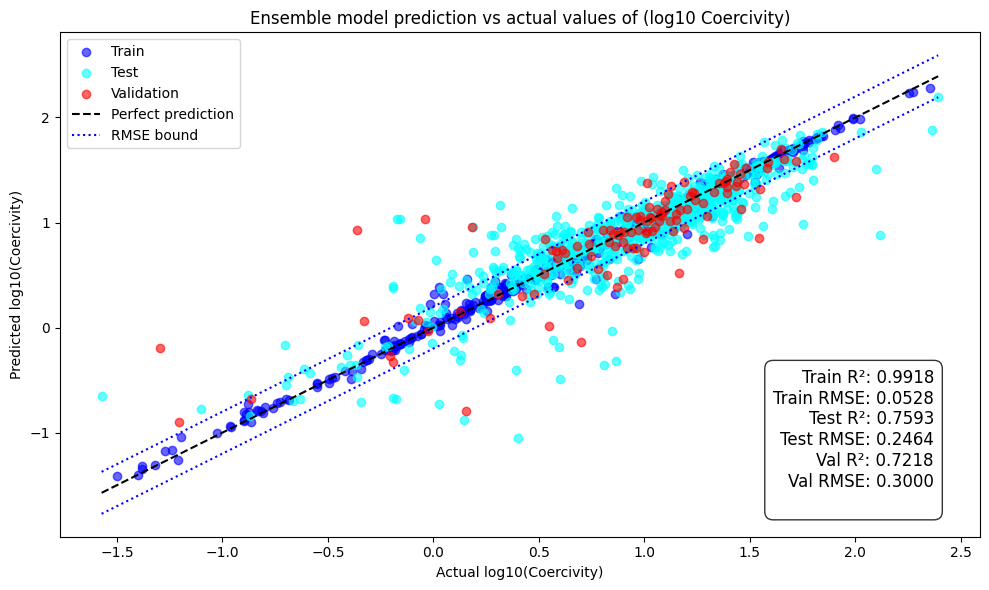

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_train, ensemble_train_preds, alpha=0.6, color='blue', label='Train')
ax.scatter(y_test, ensemble_test_preds, alpha=0.6, color='cyan', label='Test')
ax.scatter(y_val, ensemble_val_preds, alpha=0.6, color='red', label='Validation')

min_val = min(min(y_train), min(y_val), min(y_test))
max_val = max(max(y_train), max(y_val), max(y_test))
ideal_line = np.linspace(min_val, max_val, 100)
avg_rmse = (ens_train_rmse + ens_val_rmse + ens_test_rmse) / 3

ax.plot(ideal_line, ideal_line, 'k--', label='Perfect prediction')
ax.plot(ideal_line, ideal_line + avg_rmse, 'b--', linestyle=':', label='RMSE bound')
ax.plot(ideal_line, ideal_line - avg_rmse, 'b--', linestyle=':')

metrics_text = (
    f"Train R²: {ens_train_r2:.4f}\n"
    f"Train RMSE: {ens_train_rmse:.4f}\n"
    f"Test R²: {ens_test_r2:.4f}\n"
    f"Test RMSE: {ens_test_rmse:.4f}\n"
    f"Val R²: {ens_val_r2:.4f}\n"
    f"Val RMSE: {ens_val_rmse:.4f}\n"
)

ax.text(0.95, 0.05, metrics_text, transform=ax.transAxes,
        fontsize=12, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', edgecolor='black'))

ax.set_title('Ensemble model prediction vs actual values of (log10 Coercivity)')
ax.set_xlabel('Actual log10(Coercivity)')
ax.set_ylabel('Predicted log10(Coercivity)')
ax.legend()
plt.tight_layout()
plt.show()